<b>Q-Learning</b>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

np.random.seed(42)
import copy

<b>Environment Grid, Grid of 11 rows X 11 columns</b>

In [2]:
grid_rows = 11
grid_cols = 11

<b>Q-value for each state/action pair Q(s,a)
2D array give the Q value, 3d dimension is the Q value for the action
there are 4 actions: Up, Down, Right, Left
So there are 4 layers
</b>

In [3]:
q_values = np.zeros((grid_rows, grid_cols, 4))

<b>Actions: 0 - Up, 1 - Right, 2 - Down, 3 - Left</b>

In [4]:
actions = ['up', 'right', 'down', 'left']

<b>Print Grid<pre>
dollar - Goal
pound - Wall
space - Movable space
star - Path
</pre></b>

In [5]:
def print_char(x):
    if x == -100:
        return "\x1b[31m#\x1b[0m"
    if x == -1:
        return ' '
    if x == 9:
        return "\x1b[34m*\x1b[0m"
    if x == 100:
        return "\x1b[92m$\x1b[0m"

In [6]:
def print_grid(grid):
    print(' | 0| 1| 2| 3| 4| 5| 6| 7| 8| 9|10|')
    for i in range(grid_rows):
        for k in range(grid_cols):
            print('---', end='')
        print('')
        
        print(i, end='')
        for j in range(grid_cols):
            print('|', print_char(grid[i][j]), end='')
        print('|', end='')
        print('')
        
    for k in range(grid_cols):
        print('---', end='')
    print('')

<b>Reward table : define the rewards table
100 - max reward - goal
-100 - max punishment - blocked cells
-1 - allowed cells for travelling
Purpose of Q learning algorithm is to maximise the rewards. 
If we keep positive rewards then bot will keep moving unnecessarly to collect the rewards.
-ve rewards keep control on movements</b>

In [7]:
rewards = np.full((grid_rows, grid_cols), -100.)
rewards[0, 5] = 100. #set the reward for the packaging area (i.e., the goal) to 100

#define aisle locations (i.e., white squares) for rows 1 through 9
aisles = {} #store locations in a dictionary
aisles[1] = [i for i in range(1, 10)]
aisles[2] = [1, 7, 9]
aisles[3] = [i for i in range(1, 8)]
aisles[3].append(9)
aisles[4] = [3, 7]
aisles[5] = [i for i in range(11)]
aisles[6] = [5]
aisles[7] = [i for i in range(1, 10)]
aisles[8] = [3, 7]
aisles[8] = [i for i in range(11)]

aisles[9] = [i for i in range(11)]

aisles[10] = [i for i in range(11)]

#set the rewards for all aisle locations (i.e., white squares)
for row_index in range(1, 11):
    for column_index in aisles[row_index]:
        rewards[row_index, column_index] = -1.

print("\nRewards Table\n")
for row in rewards:
    print(row)

print("\nGrid\n")
print_grid(rewards)


Rewards Table

[-100. -100. -100. -100. -100.  100. -100. -100. -100. -100. -100.]
[-100.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1. -100.]
[-100.   -1. -100. -100. -100. -100. -100.   -1. -100.   -1. -100.]
[-100.   -1.   -1.   -1.   -1.   -1.   -1.   -1. -100.   -1. -100.]
[-100. -100. -100.   -1. -100. -100. -100.   -1. -100. -100. -100.]
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
[-100. -100. -100. -100. -100.   -1. -100. -100. -100. -100. -100.]
[-100.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1. -100.]
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]

Grid

 | 0| 1| 2| 3| 4| 5| 6| 7| 8| 9|10|
---------------------------------
0| #| #| #| #| #| $| #| #| #| #| #|
---------------------------------
1| #|  |  |  |  |  |  |  |  |  | #|
---------------------------------
2| #|  | #| #| #| #| #|  | #|  | #|
---------------------------------
3| #|  |  |  |  |  |  |  | #|  | #|
-

<b><pre>
TRAINING
1. To begin, choose random, non-terminal state
2. Choose action, move- up/right/down/left from current state
3. Choose action using epsilon greedy method - balanced approach of explore and exploit
4. Perform the action and move to next state
5. Receive rewards and compute temporal difference
6. Update Q-value for previos state/action pair
7. if new state is terminal state, go to step 1, else go to step 2

Run the process for 10000 episodes
</pre></b>

In [8]:
def is_terminal_state(row_index, col_index):
    if rewards[row_index, col_index] == -1. :
        return False
    return True

<b>Choose start location</b>

In [9]:
def get_starting_location():
    row_indx = np.random.randint(grid_rows)
    col_indx = np.random.randint(grid_cols)
    
    #continue choosing random row and column indexes until a non-terminal state is identified
    #(i.e., until the chosen state is a 'white square').
    while is_terminal_state(row_indx, col_indx):
        row_indx = np.random.randint(grid_rows)
        col_indx = np.random.randint(grid_cols)

    return row_indx, col_indx

<b>next_action - epsilon greedy algorithm</b>

In [10]:
def get_next_action(row_indx, col_indx, epsilon):
    if np.random.random() < epsilon:
        return np.argmax(q_values[row_indx, col_indx])
    return np.random.randint(4)

In [11]:
def get_next_location(row_indx, col_indx, action_indx):
    new_row_indx = row_indx
    new_col_indx = col_indx
    
    if actions[action_indx] == 'up' and row_indx > 0:
        new_row_indx -= 1
    elif actions[action_indx] == 'right' and col_indx < grid_cols - 1:
        new_col_indx += 1
    elif actions[action_indx] == 'down' and row_indx < grid_rows - 1:
        new_row_indx += 1
    elif actions[action_indx] == 'left' and col_indx > 0:
        new_col_indx -= 1
        
    return new_row_indx, new_col_indx

<b>get_shortest_path - using q table, find shortest path</b>

In [12]:
def get_shortest_path(start_row_indx, start_col_indx):
    
    # terminal starting position
    if is_terminal_state(start_row_indx, start_col_indx):
        return []
    else :
        #non-terminal starting position
        curr_row_indx, curr_col_indx = start_row_indx, start_col_indx
        shortest_path = []
        shortest_path.append([curr_row_indx, curr_col_indx])
        
        while not is_terminal_state(curr_row_indx, curr_col_indx):
            action_indx = get_next_action(curr_row_indx, curr_col_indx, 1.)
            
            curr_row_indx, curr_col_indx = get_next_location(curr_row_indx, curr_col_indx, action_indx)
            shortest_path.append([curr_row_indx, curr_col_indx])
        return shortest_path

<b>Train the Agent</b>

In [13]:
epsilon = 0.9
discount_factor = 0.9 #discount for future rewards
learning_rate = 0.9

episods_count = 10000

<b>Stats</b>

In [14]:
episode_lengths = np.zeros(episods_count)
episode_rewards = np.zeros(episods_count)

In [15]:
for episode in tqdm(range(episods_count), desc='Training progress'):
    row_indx, col_indx = get_starting_location()
    
    ep_len = 0
    while not is_terminal_state(row_indx, col_indx):
        ep_len = ep_len + 1
        action_indx = get_next_action(row_indx, col_indx, epsilon)
        
        old_row_indx, old_col_indx = row_indx, col_indx
        row_indx, col_indx = get_next_location(row_indx, col_indx, action_indx)
        
        #rewards
        reward = rewards[row_indx, col_indx]
        old_q_value = q_values[row_indx, col_indx, action_indx]
        temporal_difference = reward + (discount_factor + np.max(q_values[row_indx, col_indx]) - old_q_value)
        
        #update q table using temporal difference
        new_q_value = old_q_value + (learning_rate * temporal_difference)
        q_values[old_row_indx, old_col_indx, action_indx] = new_q_value
        
        episode_rewards[episode] += reward
        episode_lengths[episode] = ep_len

Training progress: 100%|███████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 3096.94it/s]


In [16]:
x = np.arange(0, episods_count)

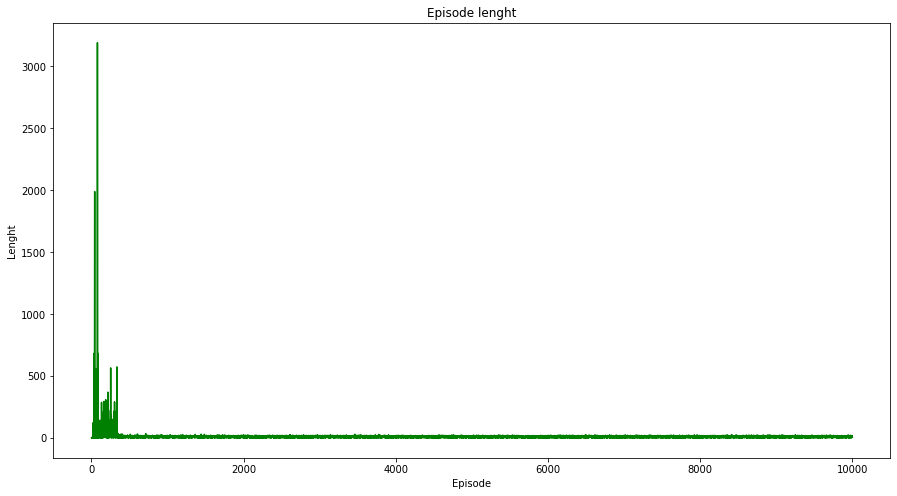

In [17]:
plt.figure(figsize=(15,8))
plt.title("Episode lenght")
plt.xlabel("Episode")
plt.ylabel("Lenght")
plt.plot(x, episode_lengths, color ="green")
plt.show()

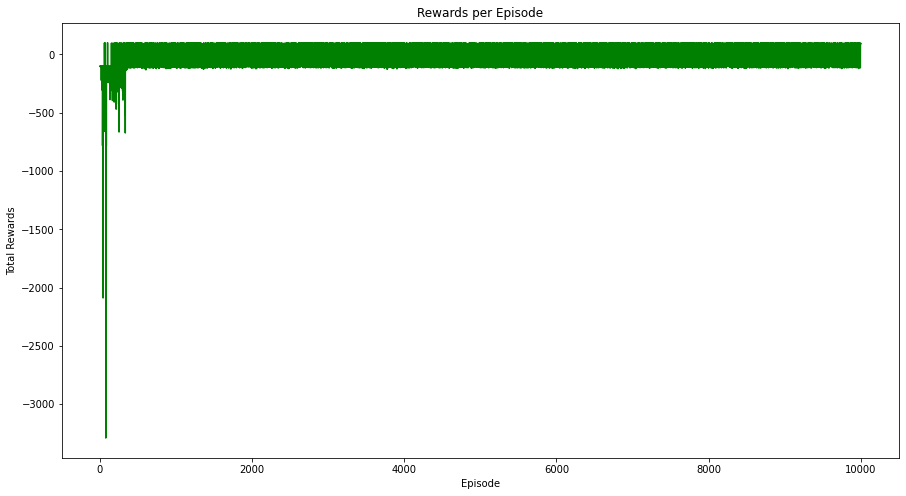

In [18]:
plt.figure(figsize=(15,8))
plt.title("Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Rewards")
plt.plot(x, episode_rewards, color ="green")
plt.show()

In [18]:
def print_path(path):
    grid = copy.copy(rewards)
    
    for i in range(len(path)):
        grid[path[i][0]][path[i][1]] = '9'
    print_grid(grid)

In [19]:
path = get_shortest_path(3, 9)
print("\nGrid - stars path from (3,9)\n")
print_path(path)


Grid - stars path from (3,9)

 | 0| 1| 2| 3| 4| 5| 6| 7| 8| 9|10|
---------------------------------
0| #| #| #| #| #| *| #| #| #| #| #|
---------------------------------
1| #|  |  |  |  | *| *| *| *| *| #|
---------------------------------
2| #|  | #| #| #| #| #|  | #| *| #|
---------------------------------
3| #|  |  |  |  |  |  |  | #| *| #|
---------------------------------
4| #| #| #|  | #| #| #|  | #| #| #|
---------------------------------
5|  |  |  |  |  |  |  |  |  |  |  |
---------------------------------
6| #| #| #| #| #|  | #| #| #| #| #|
---------------------------------
7| #|  |  |  |  |  |  |  |  |  | #|
---------------------------------
8|  |  |  |  |  |  |  |  |  |  |  |
---------------------------------
9|  |  |  |  |  |  |  |  |  |  |  |
---------------------------------
10|  |  |  |  |  |  |  |  |  |  |  |
---------------------------------


In [20]:
path = get_shortest_path(9, 6)

print("\nGrid - stars path from (9,6)\n")
print_path(path)


Grid - stars path from (9,6)

 | 0| 1| 2| 3| 4| 5| 6| 7| 8| 9|10|
---------------------------------
0| #| #| #| #| #| *| #| #| #| #| #|
---------------------------------
1| #|  |  |  |  | *| *| *|  |  | #|
---------------------------------
2| #|  | #| #| #| #| #| *| #|  | #|
---------------------------------
3| #|  |  |  |  |  |  | *| #|  | #|
---------------------------------
4| #| #| #|  | #| #| #| *| #| #| #|
---------------------------------
5|  |  |  |  |  | *| *| *|  |  |  |
---------------------------------
6| #| #| #| #| #| *| #| #| #| #| #|
---------------------------------
7| #|  |  |  |  | *|  |  |  |  | #|
---------------------------------
8|  |  |  |  |  | *|  |  |  |  |  |
---------------------------------
9|  |  |  |  |  | *| *|  |  |  |  |
---------------------------------
10|  |  |  |  |  |  |  |  |  |  |  |
---------------------------------


In [21]:
path = get_shortest_path(3, 1)
print("\nGrid - stars path from (3,1)\n")
print_path(path)


Grid - stars path from (3,1)

 | 0| 1| 2| 3| 4| 5| 6| 7| 8| 9|10|
---------------------------------
0| #| #| #| #| #| *| #| #| #| #| #|
---------------------------------
1| #| *| *| *| *| *|  |  |  |  | #|
---------------------------------
2| #| *| #| #| #| #| #|  | #|  | #|
---------------------------------
3| #| *|  |  |  |  |  |  | #|  | #|
---------------------------------
4| #| #| #|  | #| #| #|  | #| #| #|
---------------------------------
5|  |  |  |  |  |  |  |  |  |  |  |
---------------------------------
6| #| #| #| #| #|  | #| #| #| #| #|
---------------------------------
7| #|  |  |  |  |  |  |  |  |  | #|
---------------------------------
8|  |  |  |  |  |  |  |  |  |  |  |
---------------------------------
9|  |  |  |  |  |  |  |  |  |  |  |
---------------------------------
10|  |  |  |  |  |  |  |  |  |  |  |
---------------------------------


<b>Test: Get shortest path</b>

In [22]:
print(get_shortest_path(3, 9))
print(get_shortest_path(5, 0))

[[3, 9], [2, 9], [1, 9], [1, 8], [1, 7], [1, 6], [1, 5], [0, 5]]
[[5, 0], [5, 1], [5, 2], [5, 3], [5, 4], [5, 5], [5, 6], [5, 7], [4, 7], [3, 7], [2, 7], [1, 7], [1, 6], [1, 5], [0, 5]]


<b>Reverse path</b>

In [23]:
path = get_shortest_path(5, 2)
path.reverse()

print("\nPath\n")
print(path)

print("\nRewards Metrics\n")
print(rewards)

print("\nGrid - stars path to (5,2)\n")
print_path(path)


Path

[[0, 5], [1, 5], [1, 6], [1, 7], [2, 7], [3, 7], [4, 7], [5, 7], [5, 6], [5, 5], [5, 4], [5, 3], [5, 2]]

Rewards Metrics

[[-100. -100. -100. -100. -100.  100. -100. -100. -100. -100. -100.]
 [-100.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1. -100.]
 [-100.   -1. -100. -100. -100. -100. -100.   -1. -100.   -1. -100.]
 [-100.   -1.   -1.   -1.   -1.   -1.   -1.   -1. -100.   -1. -100.]
 [-100. -100. -100.   -1. -100. -100. -100.   -1. -100. -100. -100.]
 [  -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.]
 [-100. -100. -100. -100. -100.   -1. -100. -100. -100. -100. -100.]
 [-100.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1. -100.]
 [  -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.]]

Grid - stars path to (5,2)

 | 0| 1| 2| 3| 4| 5| 6| 7| 8| 9|10|
---------------------------------
0| #| #| #|

In [24]:
q_values

array([[[  0.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ]],

       [[  0.        ,   0.        ,   0.        ,   0.        ],
        [-89.19      ,  90.42578427,  70.65146378, -89.19      ],
        [-89.19      ,  90.51578427, -89.19      ,  72.37420584],
        [-89.19      ,  90.60578427, -89.19      ,  88.61162643],
        

In [36]:
rewards

array([[-100., -100., -100., -100., -100.,  100., -100., -100., -100.,
        -100., -100.],
       [-100.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.,
          -1., -100.],
       [-100.,   -1., -100., -100., -100., -100., -100.,   -1., -100.,
          -1., -100.],
       [-100.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1., -100.,
          -1., -100.],
       [-100., -100., -100.,   -1., -100., -100., -100.,   -1., -100.,
        -100., -100.],
       [  -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.,
          -1.,   -1.],
       [-100., -100., -100., -100., -100.,   -1., -100., -100., -100.,
        -100., -100.],
       [-100.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.,
          -1., -100.],
       [  -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.,
          -1.,   -1.],
       [  -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.,
          -1.,   -1.],
       [  -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -

In [25]:
import gym
import numpy as np
from keras.models import Sequential
from keras.layers import InputLayer
from keras.layers import Dense

In [26]:
discount_factor = 0.95
eps = 0.5
eps_decay_factor = 0.999
num_episodes=500

In [73]:
r1 = rewards.flatten()
r1.shape

(121,)

In [99]:
import tensorflow as tf

In [100]:
r1
x = tf.cast(r1,tf.float32) 
x

<tf.Tensor: shape=(121,), dtype=float32, numpy=
array([-100., -100., -100., -100., -100.,  100., -100., -100., -100.,
       -100., -100., -100.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.,
         -1.,   -1.,   -1., -100., -100.,   -1., -100., -100., -100.,
       -100., -100.,   -1., -100.,   -1., -100., -100.,   -1.,   -1.,
         -1.,   -1.,   -1.,   -1.,   -1., -100.,   -1., -100., -100.,
       -100., -100.,   -1., -100., -100., -100.,   -1., -100., -100.,
       -100.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.,
         -1.,   -1.,   -1., -100., -100., -100., -100., -100.,   -1.,
       -100., -100., -100., -100., -100., -100.,   -1.,   -1.,   -1.,
         -1.,   -1.,   -1.,   -1.,   -1.,   -1., -100.,   -1.,   -1.,
         -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.,
         -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.,
         -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.,
         -1.,   -1.,   -1.,   -1.], dtype=

In [60]:
rows = np.shape(r1)[0]

In [61]:
actions

['up', 'right', 'down', 'left']

In [68]:
action_count = len(actions)

In [77]:
q_values[0][0]

array([0., 0., 0., 0.])

In [101]:
q1 = []
for j in range(11):
    for i in range(11):
        #print(q_values[i][j], max(q_values[i][j]))
        q1.append(max(q_values[i][j]))
q1
y = tf.cast(q1,tf.float32) 
y

<tf.Tensor: shape=(121,), dtype=float32, numpy=
array([ 0.      ,  0.      ,  0.      ,  0.      ,  0.      , 71.613914,
        0.      ,  0.      , 55.19628 , 55.10629 , 55.016296,  0.      ,
       90.42578 , 72.37421 , 72.2842  ,  0.      , 71.70391 ,  0.      ,
       55.374695, 55.28628 , 55.196285, 55.106297,  0.      , 90.515785,
        0.      , 56.046783,  0.      , 71.793915,  0.      , 55.464695,
       55.37629 , 55.286285, 55.196297,  0.      , 90.60578 ,  0.      ,
       55.956787, 55.68652 , 71.88391 ,  0.      , 55.55469 , 55.46629 ,
       55.376286, 55.286297,  0.      , 90.695786,  0.      , 56.012585,
        0.      , 71.973915,  0.      , 55.64469 , 55.55629 , 55.466286,
       55.376297,  0.      , 90.81    ,  0.      , 56.102585,  0.      ,
       72.06391 , 55.84852 , 55.758522, 55.66852 , 55.57852 , 55.48852 ,
        0.      , 90.695786,  0.      , 56.192585,  0.      , 72.15391 ,
        0.      , 55.644688, 55.55629 , 55.4662  , 55.376297,  0.      ,
   

In [94]:
q1 = np.array(q1)

In [95]:
#q1 = q_values.flatten()
#q_values.shape
q1.shape

(121,)

In [106]:
model = Sequential()
model.add(InputLayer(batch_input_shape=(0,rows)))
model.add(Dense(20, activation='relu'))
model.add(Dense(action_count, activation='linear'))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [107]:
print("Fit model on training data")
history = model.fit(
    x,
    y,
    batch_size=16,
    epochs=2
)

Fit model on training data
Epoch 1/2


ValueError: in user code:

    File "c:\users\milind.desktop-gbr1bs2\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "c:\users\milind.desktop-gbr1bs2\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\users\milind.desktop-gbr1bs2\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "c:\users\milind.desktop-gbr1bs2\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "c:\users\milind.desktop-gbr1bs2\appdata\local\programs\python\python38\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\users\milind.desktop-gbr1bs2\appdata\local\programs\python\python38\lib\site-packages\keras\engine\input_spec.py", line 227, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential_7" (type Sequential).
    
    Input 0 of layer "dense_10" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (None,)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None,), dtype=float32)
      • training=True
      • mask=None
